In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import KFold
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

# Params and Hyper Parameters:
hidden_size = 512
learning_rate = 0.01
epochs = 50
folds = 5


In [3]:
# References https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html 

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        # x = self.flatten(x)
        return logits
    

## Running images on non-CPU:

### Mac:
Run `brew install libjpeg`

In [4]:

# Init a device with cuda or mps so that it can train faster
from typing import Literal


device: Literal['cuda'] | Literal['mps'] | Literal['cpu'] = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [5]:

def run_training(
        dataset_loader:DataLoader,
        model: NeuralNetwork,
        optimizer: optim.Optimizer,
        epochs:int
        ):
    
    criterion = nn.CrossEntropyLoss()

    train_accuracies = []
    losses = []

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0

        # Pass data to model:
        for train_x, train_y in dataset_loader:
            train_x = train_x.to(device)
            train_y = train_y.to(device)

            optimizer.zero_grad()
            outputs = model(train_x)
            loss = criterion(outputs, train_y)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += train_y.size(0)
            correct += (predicted == train_y).sum().item()
            running_loss += loss.item()

        loss = running_loss / len(dataset_loader)
        losses.append(loss)

        train_accuracy = (correct / total) * 100
        train_accuracies.append(train_accuracy)

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    return train_accuracies, losses

def run_test(test_loader: DataLoader, model: NeuralNetwork,):
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for test_x, test_y in test_loader:
            test_x = test_x.to(device)
            test_y = test_y.to(device)

            outputs = model(test_x)
            _, predicted = torch.max(outputs, 1)
            total += test_y.size(0)
            correct += (predicted == test_y).sum().item()
    
    accuracy = (correct / total) * 100
    print(f"Test Accuracy: {accuracy:.2f}%\n")

    return accuracy

In [6]:
%run ./dataset_load.py

is_load_from_csv = input("Load from CSV or images directly? Type anything to load csv, leave blank for images.")

if is_load_from_csv: dataset = load_from_csv(device) # type: ignore
else: dataset = load_from_images(device) # type: ignore

/Users/shehab/anaconda3/envs/nn/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/shehab/anaconda3/envs/nn/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /Users/shehab/anaconda3/envs/nn/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/shehab/anaconda3/envs/nn/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/shehab/anaconda3/envs/nn/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/shehab/anaconda3/envs/nn/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/shehab/anaconda3/envs/nn/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your e

In [7]:
number_of_features = dataset[0][0].numel()

print(number_of_features)

147456


Fold 1:
Epoch 1/50, Loss: 633.1223, Train Accuracy: 51.89%
Epoch 2/50, Loss: 2.1246, Train Accuracy: 58.88%
Epoch 3/50, Loss: 0.5821, Train Accuracy: 66.35%
Epoch 4/50, Loss: 0.4717, Train Accuracy: 76.55%
Epoch 5/50, Loss: 0.3759, Train Accuracy: 84.74%
Epoch 6/50, Loss: 0.3232, Train Accuracy: 86.27%
Epoch 7/50, Loss: 0.3052, Train Accuracy: 87.63%
Epoch 8/50, Loss: 0.2970, Train Accuracy: 88.11%
Epoch 9/50, Loss: 0.3832, Train Accuracy: 84.74%
Epoch 10/50, Loss: 0.3272, Train Accuracy: 86.67%
Epoch 11/50, Loss: 0.3172, Train Accuracy: 87.39%
Epoch 12/50, Loss: 0.2932, Train Accuracy: 88.84%
Epoch 13/50, Loss: 0.3440, Train Accuracy: 86.51%
Epoch 14/50, Loss: 0.2964, Train Accuracy: 88.51%
Epoch 15/50, Loss: 0.2713, Train Accuracy: 89.96%
Epoch 16/50, Loss: 0.3743, Train Accuracy: 84.98%
Epoch 17/50, Loss: 0.2970, Train Accuracy: 89.16%
Epoch 18/50, Loss: 0.4144, Train Accuracy: 82.65%
Epoch 19/50, Loss: 0.7820, Train Accuracy: 57.03%
Epoch 20/50, Loss: 0.7041, Train Accuracy: 48.03%

KeyboardInterrupt: 

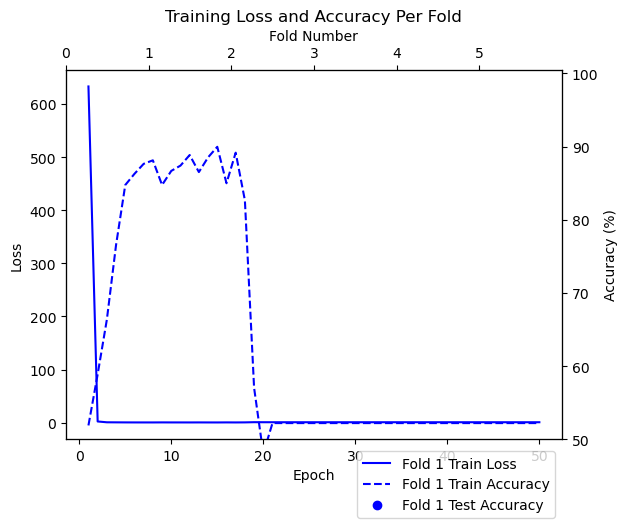

In [8]:

test_accuracies = [0.0]*folds
kfold = KFold(n_splits=folds, shuffle=True)
fold = 1
colors = 'bgcmk'
for train_idx, test_idx in kfold.split(dataset):
    print(f"Fold {fold}:")
    fold_index = fold-1

    # Init a fresh model
    model = NeuralNetwork(
        input_size=number_of_features, 
        hidden_size=hidden_size, 
        output_size=2
    )
    model = model.to(device)

    # optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    
    # Create train and test subsets
    train_subset = Subset(dataset, train_idx.tolist())
    test_subset = Subset(dataset, test_idx.tolist())
    
    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=128, shuffle=False)

    train_accuracies, train_losses = run_training(
        train_loader, 
        model, 
        optimizer, 
        epochs
    )

    test_accuracy = run_test(test_loader, model)

    
    test_accuracies[fold_index] = test_accuracy

    # Plot for this fold
    fig, left_y_axis = plt.subplots()
    right_y_axis = left_y_axis.twinx()
    top_x_axis = right_y_axis.twiny()

    left_y_axis.plot(range(1, epochs + 1), train_losses, colors[fold_index]+'-',  label=f'Fold {fold} Train Loss')

    top_x_axis.plot(fold, test_accuracy, colors[fold_index]+'o', label=f'Fold {fold} Test Accuracy')

    right_y_axis.plot(range(1, epochs + 1), train_accuracies, colors[fold_index]+'--', label=f'Fold {fold} Train Accuracy')

    plt.title('Training Loss and Accuracy Per Fold')

    left_y_axis.set_xlabel('Epoch')
    left_y_axis.set_ylabel('Loss')

    right_y_axis.set_ylabel('Accuracy (%)')
    right_y_axis.set_ylim(50.0, 100.5)

    top_x_axis.set_xlim(0, folds+1)
    top_x_axis.set_xticks(range(folds+1))
    top_x_axis.set_xlabel("Fold Number")
    fig.legend( bbox_to_anchor=(0.9,0.1))
    fig.savefig(f'training_loss_fold{fold}.png', bbox_inches='tight') 

    fold += 1

plt.figure(figsize=(8, 6))
plt.scatter([f+1 for f in range(folds)], test_accuracies, color='purple', s=100, label='Test Accuracy')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy (%)')
plt.xlim(0, folds+1)
plt.xticks(range(folds+1))

plt.title('Test Accuracy Per Fold')

plt.savefig('test_accuracy.png', bbox_inches='tight') 

